In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read csv
df = pd.read_csv('export.csv', low_memory=False)
df = df.sample(n=500_000, random_state=42)
df.head()

,user_id,age,sex,country,checkin_date,trackable_id,trackable_type,trackable_name,trackable_value
7166996,QEVuQwEAxPJhDj830ngZ1Tj9q+2Gpg==,26.0,doesnt_say,US,2019-07-01,1451,Tag,washed dishes,NaN
6080971,QEVuQwEAUeR3q06Edzu7zS9nTzjPhA==,34.0,female,US,2019-05-21,33649,Tag,muffled both ears,NaN
7951875,QEVuQwEApxEBH8fQ/QfbwDfPFKPuQA==,21.0,female,US,2018-08-19,152,Symptom,Nausea,2
1455697,QEVuQwEApEDSYfTHIwuOc7y7Z7HaEQ==,28.0,female,US,2017-11-18,42117,Weather,humidity,21.0
7569896,QEVuQwEAUyp9pawasz58gdoQT6c+UA==,40.0,female,US,2019-12-01,406,Symptom,Anaphylaxis,0


In [3]:
# Drop rows with missing essential data
df.dropna(
    subset=['age', 'sex', 'trackable_name', 'trackable_value'], inplace=True)


In [4]:
df = df[(df['age'] > 0) & (df['age'] < 150)]

In [5]:
# Convert 'checkin_date' to datetime
df['checkin_date'] = pd.to_datetime(df['checkin_date'])

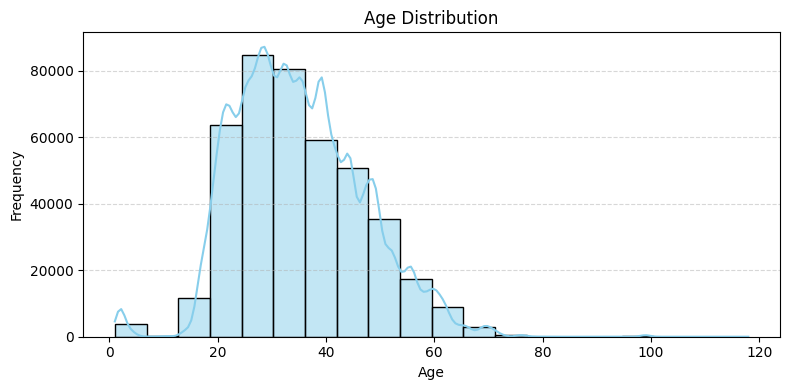

In [6]:
# Age Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/w8/lt3p8txs03x25kz_1lwbhh_w0000gn/T/ipykernel_16569/2535105102.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex', data=df, palette='pastel')


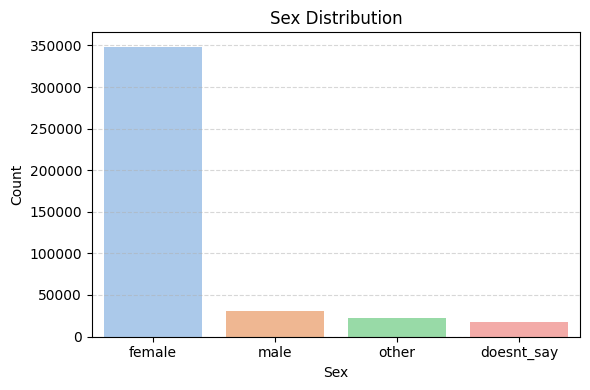

In [7]:
# Sex Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df, palette='pastel')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/w8/lt3p8txs03x25kz_1lwbhh_w0000gn/T/ipykernel_16569/2664052728.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_symptoms.index, y=top_symptoms.values, palette='coolwarm')


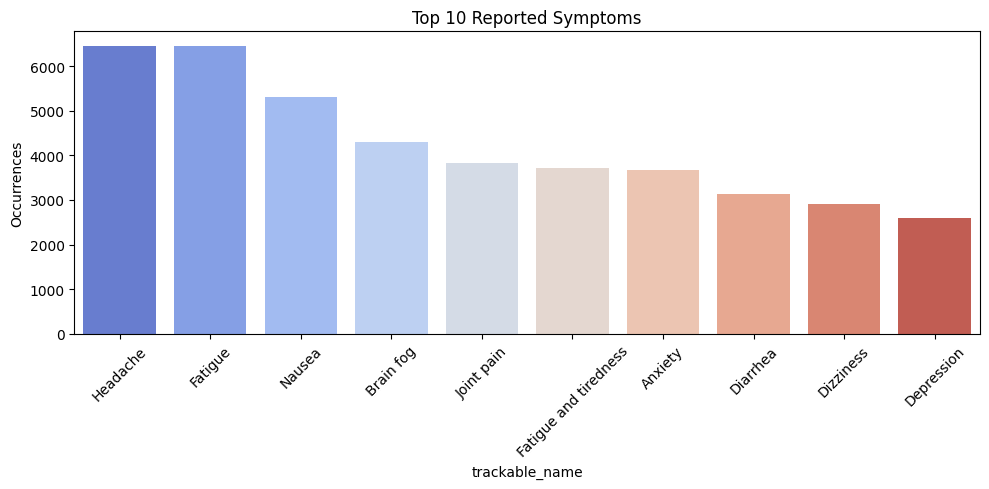

In [8]:
# Most Tracked Symptoms
symptom_df = df[df['trackable_type'] == 'Symptom']
plt.figure(figsize=(10, 5))
top_symptoms = symptom_df['trackable_name'].value_counts().nlargest(10)
sns.barplot(x=top_symptoms.index, y=top_symptoms.values, palette='coolwarm')
plt.title('Top 10 Reported Symptoms')
plt.xticks(rotation=45)
plt.ylabel('Occurrences')
plt.tight_layout()
plt.show()

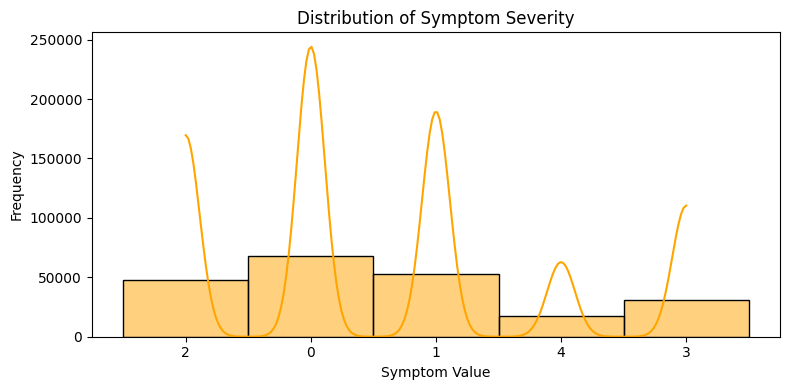

In [9]:
# Symptom Value Distribution
plt.figure(figsize=(8, 4))
sns.histplot(symptom_df['trackable_value'], bins=30, kde=True, color='orange')
plt.title('Distribution of Symptom Severity')
plt.xlabel('Symptom Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [10]:
# Extract symptom-related rows
symptom_df = df[df['trackable_type'] == 'Symptom']

In [11]:
# Pivot symptom data to wide format
symptom_pivot = symptom_df.pivot_table(index='user_id',
                                      columns='trackable_name',
                                      values='trackable_value',
                                      aggfunc='max').fillna(0)

In [12]:
# Merge demographic info (age, sex) with symptoms
demographics = df[['user_id', 'age', 'sex']].drop_duplicates().set_index('user_id')
data = symptom_pivot.merge(demographics, left_index=True, right_index=True)


In [13]:
# Encode 'sex' column
le = LabelEncoder()
data['sex'] = le.fit_transform(data['sex'])

In [14]:
# Assuming 'Fatigue' symptom_value > threshold indicates severity
data['target'] = (data['Fatigue'].astype(int) > 3).astype(int)

In [15]:
print(df[df['trackable_type'] == 'Symptom']['trackable_name'].unique())


['Nausea' 'Anaphylaxis' 'Brain fog' ... 'right shoulder swelling'
 'Upper leg muscle soreness'
 'feeling better briefly while or just after going to the bathroom']


In [16]:
# Drop 'Fatigue' from features to prevent data leakage
X = data.drop(columns=['target', 'Fatigue'])
y = data['target']

In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [18]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Build and Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# Model Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.966343411294923
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3394
           1       0.00      0.00      0.00       112

    accuracy                           0.97      3506
   macro avg       0.48      0.50      0.49      3506
weighted avg       0.94      0.97      0.95      3506



/var/folders/w8/lt3p8txs03x25kz_1lwbhh_w0000gn/T/ipykernel_16569/2224112499.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='Accuracy', data=acc_df, palette='Set2')


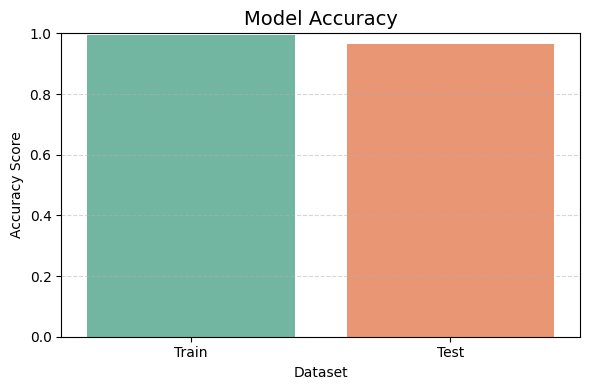

In [21]:
# Predict on training and testing data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Accuracy values
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# bar plot
acc_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Accuracy': [train_acc, test_acc]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Dataset', y='Accuracy', data=acc_df, palette='Set2')
plt.title('Model Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()